In [1]:
import argparse
import datetime
import json
import numpy as np
import os
import time
import timm.optim.optim_factory as optim_factory
from pathlib import Path
from loss.loss import WeightedMSE
import torch
import torch.backends.cudnn as cudnn
try:
    from tensorboardX import SummaryWriter
except:
    from torch.utils.tensorboard import SummaryWriter

import timm

assert timm.__version__ == "0.3.2" # version check
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

import util_mamba.lr_decay as lrd
import util_mamba.misc as misc
from util_mamba.datasets import build_dataset
from util_mamba.pos_embed import interpolate_pos_embed
from util_mamba.misc import NativeScalerWithGradNormCount as NativeScaler
from data_provider_labeled import Train as Trainset
import yaml
from attrdict import AttrDict
from utils.show import show_one
from utils.shift_channels import shift_func
from segmamba import SegMamba

from engine_finetune import train_one_epoch, evaluate

In [2]:
cfg_file = 'seg_3d_cremiC_data100'
with open('/data/ydchen/VLP/wafer4/config/' + cfg_file + '.yaml', 'r') as f:
    cfg = AttrDict(yaml.safe_load(f))

In [3]:
dataset_train = Trainset(cfg, [16,256,256])
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

load cremiC_inputs.h5 ...
raw data shape:  [100, 1250, 1250]


In [4]:
model = SegMamba(in_chans=1, out_chans=3)
model.load_state_dict(torch.load('//h3cstore_ns/EM_pretrain/mamba_seg_EM/EM_CREMIC_without_pre/checkpoint-399.pth')['model'])
device = torch.device('cuda')
model = model.to(device)

In [5]:
for i, (data,affi,weight_map) in enumerate(dataloader):
    print(data.shape)
    print(affi.shape)
    print(weight_map.shape)
    data = data.to(device)
    affi = affi.to(device)
    weight_map = weight_map.to(device)
    output = model(data)
    print(output.shape)
    # show_one(data[0,0].cpu().numpy(), affi[0].cpu().numpy(), output[0].cpu().numpy(), weight_map[0].cpu().numpy())
    break

torch.Size([1, 1, 16, 256, 256])
torch.Size([1, 3, 16, 256, 256])
torch.Size([1, 3, 16, 256, 256])
torch.Size([1, 3, 16, 256, 256])


In [6]:
data.max(),data.min()

(tensor(0.8471, device='cuda:0'), tensor(0., device='cuda:0'))

In [7]:
from matplotlib import pyplot as plt
affi_show = affi[0,:,10].cpu().numpy().transpose(1,2,0)
out_show = output[0,:,10].detach().cpu().numpy().transpose(1,2,0)
plt.subplot(1,2,1)
plt.imshow(affi_show)
plt.subplot(1,2,2)
plt.imshow(out_show)


In [8]:
# sliding window infer
from monai.inferers import sliding_window_inference
data, label, gt_aff = dataset_train.valid_provide()

valid load cremiC_inputs.h5 ...


In [9]:
label.shape

(25, 1250, 1250)

In [9]:
data.shape
data = torch.tensor(data)
data = data.unsqueeze(0).unsqueeze(0).to(device)
data = data / 255

In [10]:
device = torch.device('cuda:3')
model = model.to(device)
data = data.to(device)

In [11]:
with torch.no_grad():
    pred_out = sliding_window_inference(data, (16,256,256), 12, model)

In [14]:
pred_out.shape, gt_aff.shape

(torch.Size([1, 3, 25, 1250, 1250]), (3, 25, 1250, 1250))

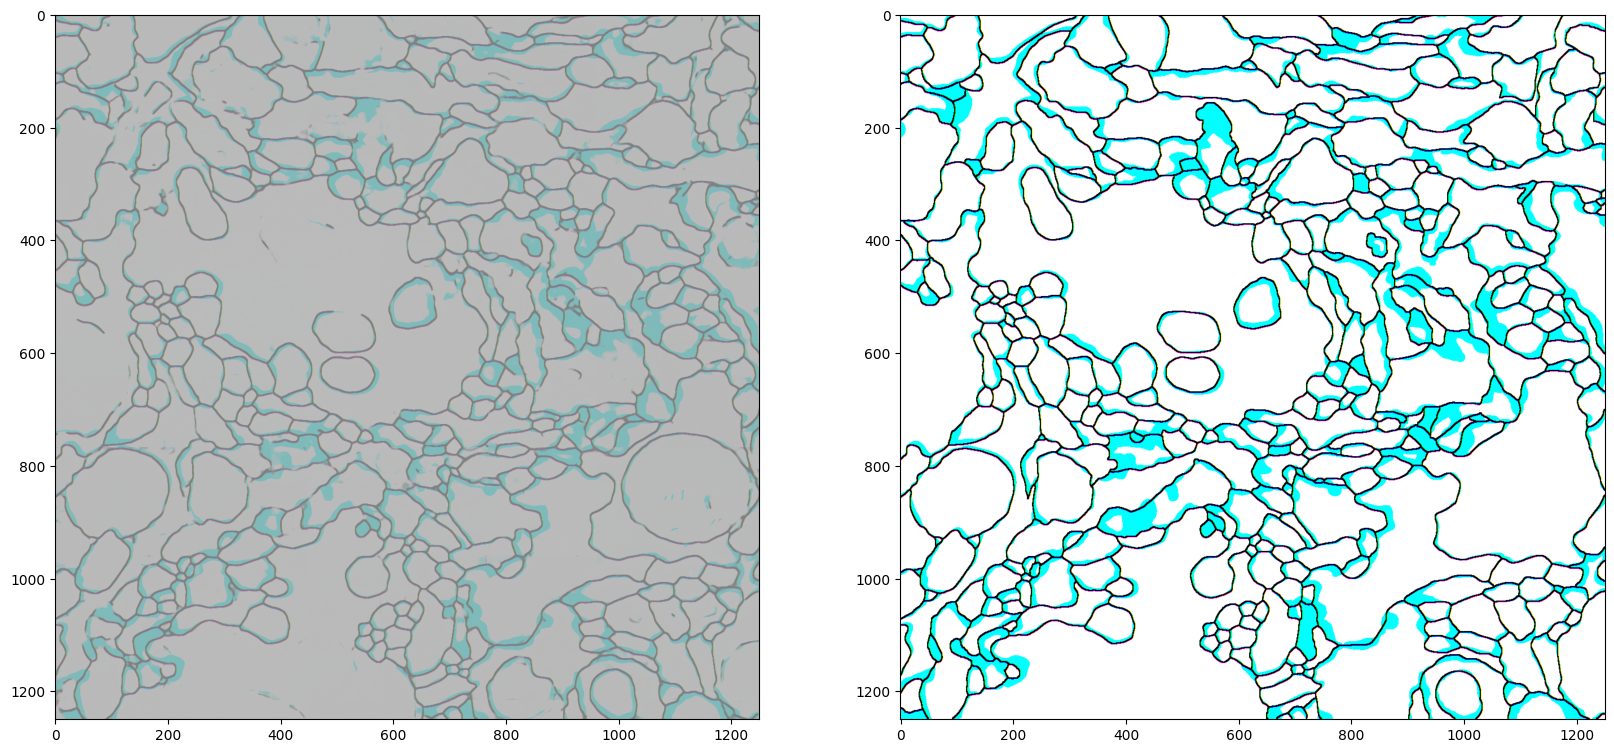

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pred_out[0,:,8].cpu().numpy().transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(gt_aff[:,8].transpose(1,2,0))

In [13]:
def draw_fragments_3d(pred):
    d,m,n = pred.shape
    ids = np.unique(pred)
    size = len(ids)
    print("the neurons number of pred is %d" % size)
    color_pred = np.zeros([d, m, n, 3])
    idx = np.searchsorted(ids, pred)
    for i in range(3):
        color_val = np.random.randint(0, 255, ids.shape)
        if ids[0] == 0:
            color_val[0] = 0
        color_pred[:,:,:,i] = color_val[idx]
    color_pred = color_pred
    return color_pred

In [14]:
label_color = draw_fragments_3d(label)

the neurons number of pred is 585


In [22]:
gt_aff1.shape

(3, 1250, 1250)

In [15]:
from PIL import Image
gt_aff1 = gt_aff[:,0]
gt_aff_img = Image.fromarray((gt_aff1*255).astype(np.uint8).transpose(1,2,0))
gt_aff_img.show()

In [16]:
data1 = data.cpu().numpy()
data1 = data1.squeeze()*255
data_img = Image.fromarray(data1[0].astype(np.uint8))
data_img

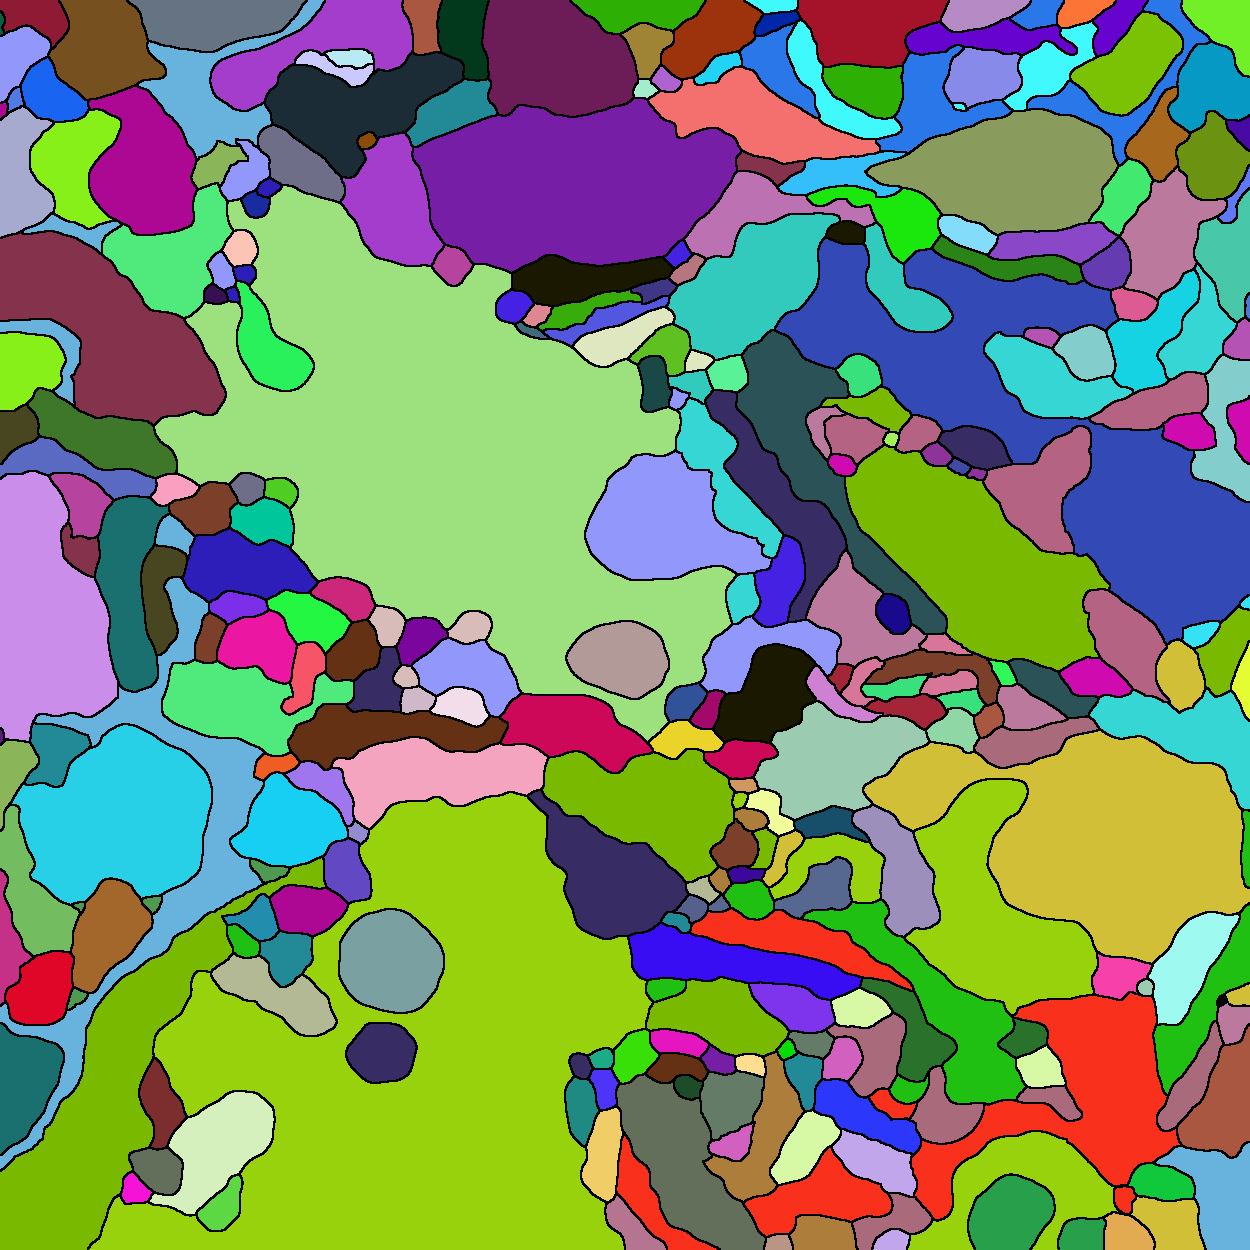

In [17]:
from PIL import Image

label_img = Image.fromarray(label_color[0].astype(np.uint8))
label_img

In [25]:
def norm01(x, mode=1):
    if mode==0:
        return (x.max()-x) / (x.max() - x.min())
    elif mode == 1:
        x = np.clip(x, a_min=0,a_max=1)
        return x

In [26]:
from utils.fragment import watershed, randomlabel
import numpy as np
pred_out_npz = np.load('pred_out.npz')
label_npz = np.load('label.npz')
pred_out = pred_out_npz['arr_0']
label = label_npz['arr_0']
pred_out = norm01(pred_out)
fragments = watershed(pred_out, 'maxima_distance')
import waterz
sf = 'OneMinus<HistogramQuantileAffinity<RegionGraphType, 50, ScoreValue, 256>>'
seg_waterz = list(waterz.agglomerate(pred_out, [0.50],
            fragments=fragments,
            scoring_function=sf,
            discretize_queue=256))[0]
from skimage.metrics import adapted_rand_error as adapted_rand_ref
from skimage.metrics import variation_of_information as voi_ref
arand_waterz = adapted_rand_ref(label, seg_waterz, ignore_labels=(0))[0]
voi_split, voi_merge = voi_ref(label, seg_waterz)
voi_sum_waterz = voi_split + voi_merge
print(f"ARAND: {arand_waterz}, VOI: {voi_sum_waterz}, VOI_MERGE: {voi_merge}, VOI_SPLIT: {voi_split}")

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 166078 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 805150
merging until threshold 0.5
computing initial scores
merging until 0.5
min edge score 0.00195312
threshold exceeded
merged 164943 edges
extracting segmentation
ARAND: 0.8443736201218851, VOI: 4.647612532346745, VOI_MERGE: 3.7117347622001136, VOI_SPLIT: 0.9358777701466312


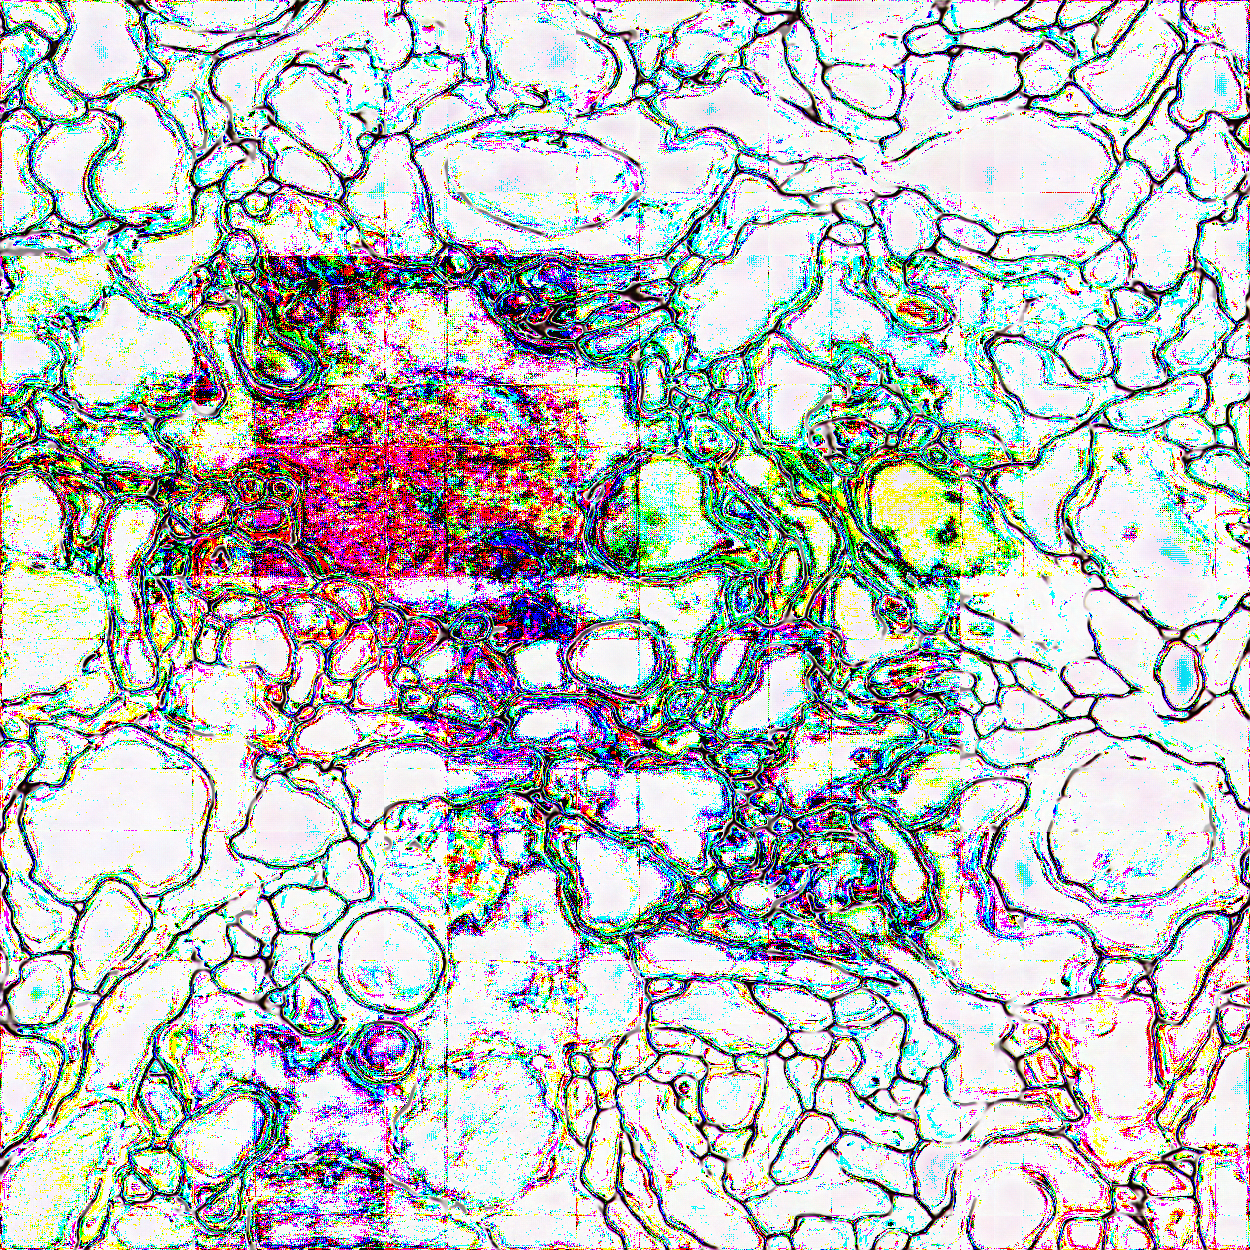

In [18]:
from PIL import Image
import numpy as np
pred_out_npz = np.load('pred_out.npz')
# label_npz = np.load('label.npz')
pred_out = pred_out_npz['arr_0']
# label = label_npz['arr_0']
pred_out1 = pred_out[:,0]
pred_out1_img = Image.fromarray((pred_out1*255).astype(np.uint8).transpose(1,2,0))
pred_out1_img.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


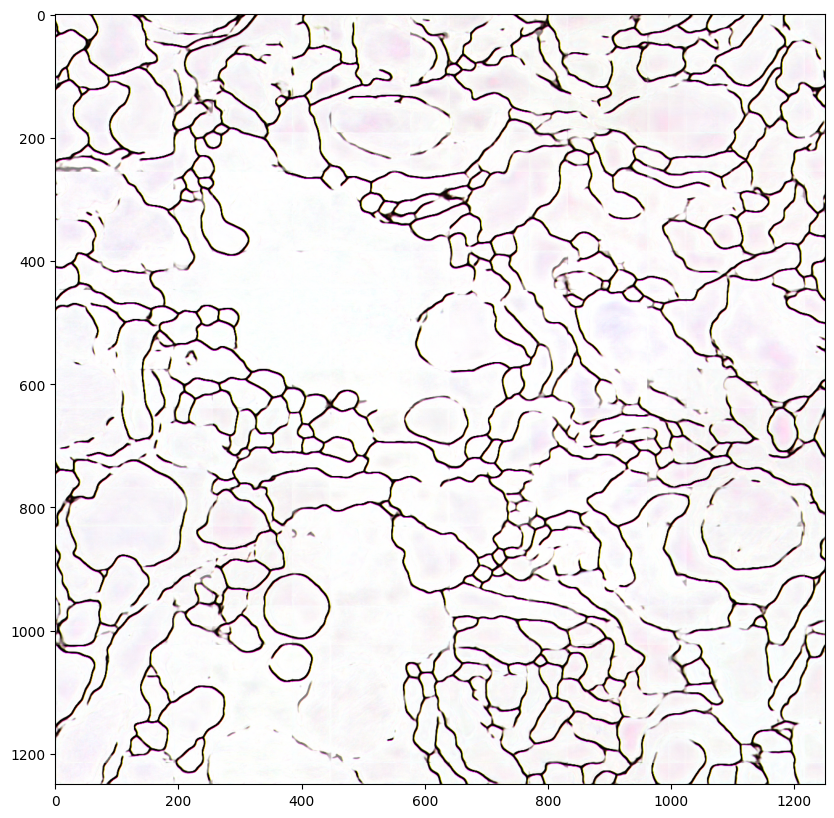

In [19]:
from PIL import Image
import numpy as np
pred_out_npz = np.load('pred_out.npz')
# label_npz = np.load('label.npz')
pred_out = pred_out_npz['arr_0']
# label = label_npz['arr_0']
plt.figure(figsize=(20,10))
plt.imshow(pred_out[:,0].transpose(1,2,0))

In [20]:
pred_out.max(),pred_out.min()

(1.3551601, -0.120526776)